In [1]:
%matplotlib ipympl
import control as ct
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# plt.rcParams["animation.html"] = "jshtml"

import hydrostat_cell as hc
import draw_nodes

import importlib

# Individual Cells

Individual cells connect with each other to create one connected "tissue". A cell consists of vertices and muscles (edges).

A cell always maintains a constant volume. Forces act on vertices and any changes in volume are compensated by the free vertices. If a cell is overconstrained, then movement is not possible. 

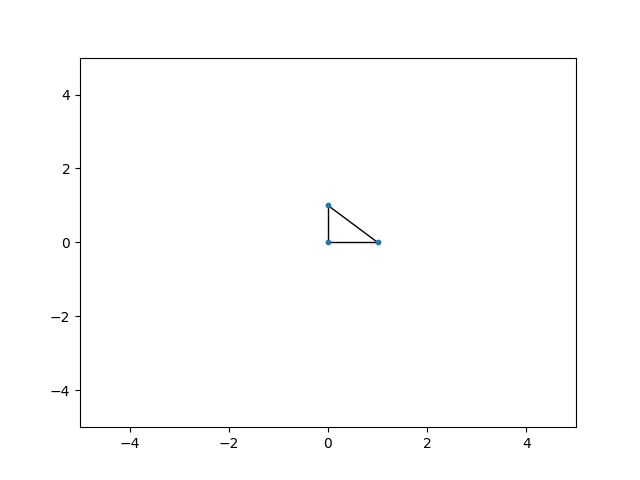

In [2]:
importlib.reload(hc)
importlib.reload(draw_nodes)

cell = hc.HydrostatCell(base=True)
drawer = draw_nodes.NodeDrawer(cell)

In [3]:
# Math scratch
import sympy as sp

# Coordinate Calcs
def wedge_prod(v1, v2):
    return v1[0] * v2[1] - v1[1] * v2[0]

vertices = np.array([
    [.2, 1], 
    [0, 2],
    [3, 3]
])

vec13 = vertices[2] - vertices[0]
vec12 = vertices[1] - vertices[0]
vec23 = vertices[2] - vertices[1]

V1 = 0.5 * wedge_prod(vec13, vec12)
V2 = 0.5 * wedge_prod(vec23, vec12)
V3 = 0.5 * wedge_prod(vec13, vec23)
print(V1, V2, V3)



1.5999999999999999 1.6 -1.6


In [4]:
# Constrained Optimization

simulation_steps = 1000
dt = 0.01
t = np.arange(0, (simulation_steps+1) * dt, dt)

q0 = np.array([0, 0, 1, 0, 0, 1]).reshape(-1, 1)
dq0 = np.zeros((6, 1))
M = np.diag([1, 1, 1, 1, 1, 1])
W = np.linalg.inv(M)
B = np.diag([1, 1, 1, 1, 1, 1])
Q = np.zeros((simulation_steps, 6, 1))
Q[:,2] = -np.ones((simulation_steps, 1))/2
Q[:,3] = np.ones((simulation_steps, 1))/2
ks = 100
kd = 1

def cell_volume(q):
    return 0.5 * ((q[2] - q[0]) * (q[5] - q[1]) - (q[3] - q[1]) * (q[4] - q[0]))

def C(q):
    return np.array([
        0.5 * ((q[2] - q[0]) * (q[5] - q[1]) - (q[3] - q[1]) * (q[4] - q[0])) - cell_volume(q0)
    ]).reshape(1, 1)

def jacobian(q):
    return 0.5 * np.array([
        q[3] - q[5],
        q[4] - q[2],
        q[5] - q[1],
        q[0] - q[4],
        q[1] - q[3],
        q[2] - q[0]
    ]).reshape(1, 6)

def dJ(q, dq):
    return 0.5 * np.array([
        dq[3] - dq[5],
        dq[4] - dq[2],
        dq[5] - dq[1],
        dq[0] - dq[4],
        dq[1] - dq[3],
        dq[2] - dq[0]
    ]).reshape(1, 6)

qs = np.empty((simulation_steps+1, 6, 1))
dqs = np.empty((simulation_steps+1, 6, 1))
qs[0] = q0
dqs[0] = dq0

for idx in range(simulation_steps):
    q = qs[idx]
    dq = dqs[idx]
    J = jacobian(q)
    lagrange_mult = np.array([
        np.linalg.inv(J @ W @ J.T)
        @ ((J @ W @ B - dJ(q, dq)) @ dq - J @ W @ Q[idx] - ks * C(q) - kd * J @ dq)
    ]).reshape(1, 1)

    reactions = J.T @ lagrange_mult
    ddq = W @ (Q[idx] + reactions) - W @ B @ dq
    dqs[idx+1] = dq + ddq * dt
    qs[idx+1] = q + dq * dt


In [5]:
cell_volumes = cell_volume(qs.transpose(1, 0, 2))
print(qs[0])
print(cell_volume(qs[0]))
print(cell_volume(qs[-1]))
print(qs[-1])

coords = qs[-1]
print(coords[4] - coords[0])
max_vol_error = np.max(np.abs(cell_volumes - cell_volumes[0]))
print(max_vol_error)

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
[0.5]
[0.50000181]
[[-0.24436256]
 [-0.58561673]
 [-2.04624652]
 [ 4.5016188 ]
 [-1.20941251]
 [ 1.58401952]]
[-0.96504995]
1.0970048391067966e-05


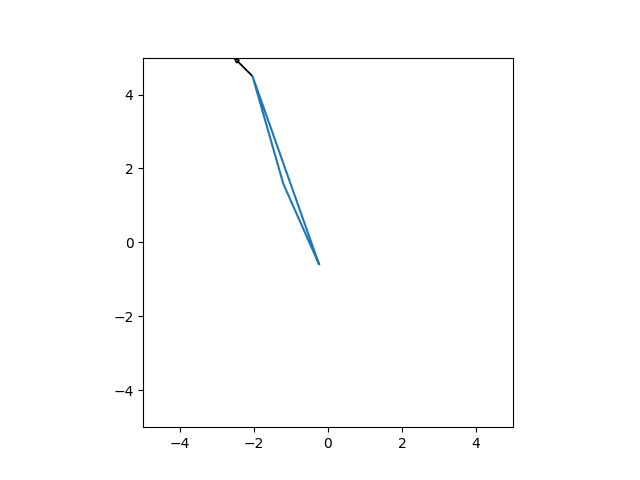

In [6]:
def get_triangle_coords(q):
    return ([q[0], q[2], q[4], q[0]], [q[1], q[3], q[5], q[1]])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
tri, = ax.plot(*get_triangle_coords(qs[0]))
arrow = ax.arrow(qs[0,2,0], qs[0,3,0], Q[0,2,0], Q[0,3,0], length_includes_head=True, head_width=.1)


def update(frame):
    tri.set_data(*get_triangle_coords(qs[frame]))
    arrow.set_data(x=qs[frame, 2, 0], y=qs[frame, 3, 0], dx=Q[frame, 2, 0], dy=Q[frame, 3, 0])
    return tri, arrow,

ani = animation.FuncAnimation(fig, update, frames=simulation_steps, interval=10)
ani.save('triangle_animation.mp4')
